In [1]:
import os
import uuid
import random
import psycopg2
import numpy as np
import scipy.interpolate
import scipy.io as sio
import matplotlib.cm as cm
import matplotlib.tri as mtri
import matplotlib.pyplot as plt

from psycopg2 import Error
from scipy.fft import fft, rfftfreq

In [2]:
__connection = psycopg2.connect(user="postgres",
                                     password='2325070307',
                                     host="127.0.0.1",
                                     port="5432",
                                     database='tpu')
cursor = __connection.cursor()

In [42]:
alpha = 4
model_name = '111'
angle = 0
if alpha == '4' or alpha == 4:
    cursor.execute("""
                select pressure_coefficients
                from models_alpha_4
                where model_id = (
                select model_id
                from experiments_alpha_4
                where model_name = (%s)
                ) and angle = (%s)
            """, (model_name, angle))

elif alpha == '6' or alpha == 6:
    cursor.execute("""
                select pressure_coefficients
                from models_alpha_6
                where model_id = (
                select model_id
                from experiments_alpha_6
                where model_name = (%s)
                ) and angle = (%s)
            """, (model_name, angle))
__connection.commit()
pressure_coefficients = cursor.fetchall()[0][0]

In [251]:
pr_norm = np.array(pressure_coefficients)/1000

In [41]:
if alpha == '4' or alpha == 4:
    cursor.execute("""
                select x_coordinates, z_coordinates
                from experiments_alpha_4
                where model_name = (%s)
            """, (model_name,))

elif alpha == '6' or alpha == 6:
    cursor.execute("""
                select x_coordinates, z_coordinates
                from experiments_alpha_6
                where model_name = (%s)
            """, (model_name,))
__connection.commit()
x, z = cursor.fetchall()[0]

In [45]:
breadth, depth, height = int(model_name[0]) / 10, int(model_name[1]) / 10, int(model_name[2]) / 10
count_sensors_on_model = len(pr_norm[0])
count_sensors_on_middle = int(model_name[0]) * 5
count_sensors_on_side = int(model_name[1]) * 5
count_row = count_sensors_on_model // (2 * (count_sensors_on_middle + count_sensors_on_side))
v2 = breadth
v3 = breadth + depth
v4 = 2 * breadth + depth
mid13_x = breadth / 2
mid24_x = depth / 2
mid13_x = breadth / 2
mid_z = height / 2

NameError: name 'pr_norm' is not defined

In [44]:
pr_coeff = np.array(pressure_coefficients)/1000
breadth, depth, height = int(model_name[0]) / 10, int(model_name[1]) / 10, int(model_name[2]) / 10
v2 = breadth
v3 = breadth + depth
v4 = 2 * breadth + depth
mid13_x = breadth / 2
mid24_x = depth / 2
count_sensors_on_model = len(pr_coeff[0])
count_sensors_on_middle = int(model_name[0]) * 5
count_sensors_on_side = int(model_name[1]) * 5
count_row = count_sensors_on_model // (2 * (count_sensors_on_middle + count_sensors_on_side))

In [46]:

x = np.reshape(x, (count_row, -1))
x = np.split(x, [count_sensors_on_middle,
                 count_sensors_on_middle + count_sensors_on_side,
                 2 * count_sensors_on_middle + count_sensors_on_side,
                 2 * (count_sensors_on_middle + count_sensors_on_side)
                 ], axis=1)

del x[4]
x[1] -= v2
x[2] -= v3
x[3] -= v4
mx = np.array([
    abs(x[0] - mid13_x),
    abs(x[1] - mid24_x),
    abs(x[2] - mid13_x),
    abs(x[3] - mid24_x),
])

In [52]:
sum_cmz = []

coeffs_norm_13 = [1 if i <= count_sensors_on_middle//2  else -1 for i in range(count_sensors_on_middle)]
coeffs_norm_24 = [1 if i <= count_sensors_on_side//2  else -1 for i in range(count_sensors_on_side)]
for coeff in pr_coeff:

    coeff = np.reshape(coeff, (count_row, -1))
    coeff = np.split(coeff, [count_sensors_on_middle,
                             count_sensors_on_middle + count_sensors_on_side,
                             2 * count_sensors_on_middle + count_sensors_on_side,
                             2 * (count_sensors_on_middle + count_sensors_on_side)
                             ], axis=1)
    del coeff[4]
    for i in range(4):
        if i in [0,2]:
            coeff[i] *=coeffs_norm_13
        else:
            coeff[i] *=coeffs_norm_24
    cmz = mx*coeff
    sum_cmz.append(np.sum(cmz))

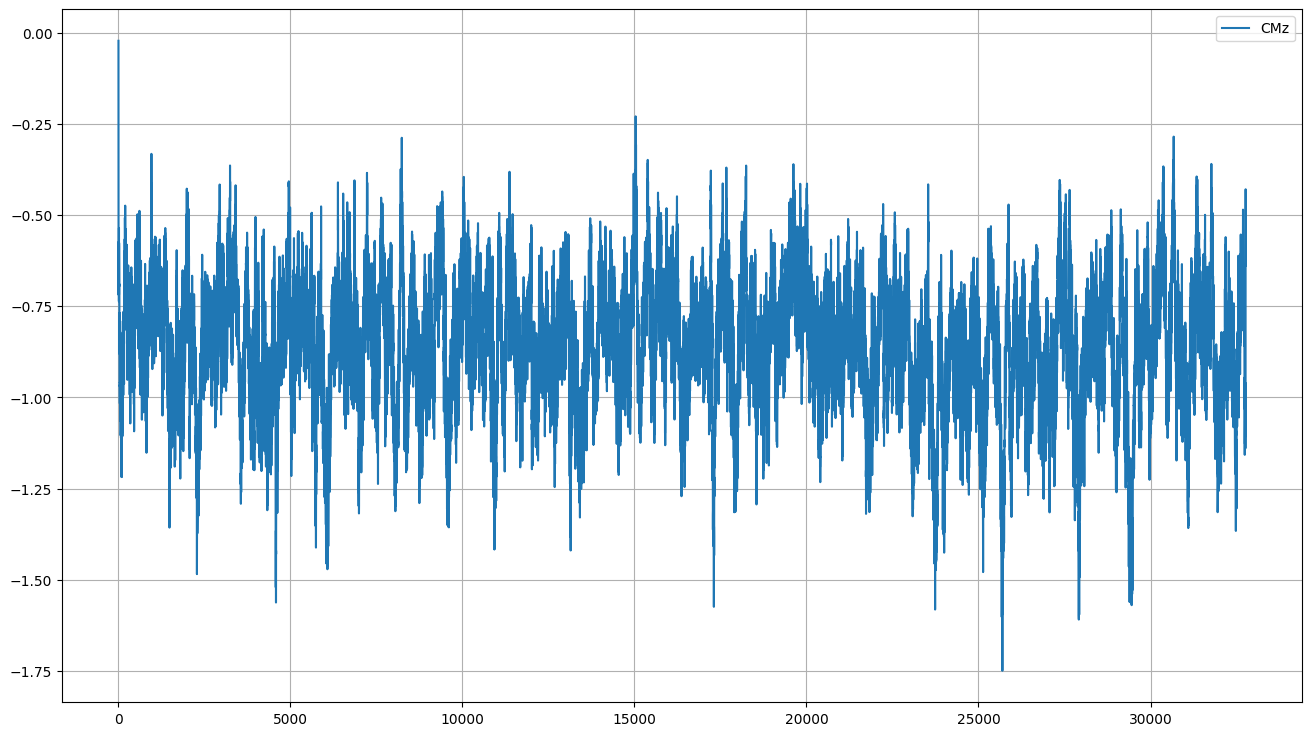

In [53]:
plt.figure(figsize=(16,9))
plt.plot(list(range(1,32769)),sum_cmz,label='CMz')
plt.legend()
plt.grid()
plt.show()

In [254]:
mean_pr = np.mean(pr_norm,axis=0)
mean_pr = np.reshape(mean_pr, (count_row, -1))
mean_pr = np.split(mean_pr, [count_sensors_on_middle,
                             count_sensors_on_middle + count_sensors_on_side,
                             2 * count_sensors_on_middle + count_sensors_on_side,
                             2 * (count_sensors_on_middle + count_sensors_on_side)
                             ], axis=1)
del mean_pr[4]
mean_pr

[array([[0.63784979, 0.75246725, 0.75709412, 0.75326111, 0.64909683],
        [0.68849747, 0.92879584, 0.9605867 , 0.92891296, 0.68795883],
        [0.62320154, 0.88008801, 0.92363824, 0.88091302, 0.62181122],
        [0.48330771, 0.76740866, 0.81601962, 0.77286655, 0.50327991],
        [0.37576022, 0.75821518, 0.79266379, 0.7288855 , 0.37109271]]),
 array([[-1.32753845, -1.31243759, -1.06125641, -0.7628273 , -0.55787033],
        [-1.22580017, -1.29017084, -1.11184354, -0.82173282, -0.61292117],
        [-1.15426184, -1.21993256, -1.09408136, -0.83791516, -0.65477634],
        [-1.15460892, -1.19927493, -1.05468448, -0.81595862, -0.64603415],
        [-1.17326157, -1.15450433, -0.96124301, -0.72660229, -0.55918463]]),
 array([[-0.49776068, -0.48607898, -0.48338226, -0.48961966, -0.50216214],
        [-0.51166525, -0.49957541, -0.494638  , -0.50283713, -0.51391318],
        [-0.51027325, -0.487599  , -0.47380435, -0.48406006, -0.50871219],
        [-0.49485352, -0.46196545, -0.44472018

In [255]:
x = np.reshape(x, (count_row, -1))
x = np.split(x, [count_sensors_on_middle,
                 count_sensors_on_middle + count_sensors_on_side,
                 2 * count_sensors_on_middle + count_sensors_on_side,
                 2 * (count_sensors_on_middle + count_sensors_on_side)
                 ], axis=1)

z = np.reshape(z, (count_row, -1))
z = np.split(z, [count_sensors_on_middle,
                 count_sensors_on_middle + count_sensors_on_side,
                 2 * count_sensors_on_middle + count_sensors_on_side,
                 2 * (count_sensors_on_middle + count_sensors_on_side)
                 ], axis=1)

del x[4]
del z[4]
x[1] -= v2
x[2] -= v3
x[3] -= v4

In [183]:
x

[array([[0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29]]),
 array([[0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
      

In [184]:
z

[array([[0.28125, 0.28125, 0.28125, 0.28125, 0.28125, 0.28125, 0.28125,
         0.28125, 0.28125, 0.28125, 0.28125, 0.28125, 0.28125, 0.28125,
         0.28125],
        [0.24375, 0.24375, 0.24375, 0.24375, 0.24375, 0.24375, 0.24375,
         0.24375, 0.24375, 0.24375, 0.24375, 0.24375, 0.24375, 0.24375,
         0.24375],
        [0.20625, 0.20625, 0.20625, 0.20625, 0.20625, 0.20625, 0.20625,
         0.20625, 0.20625, 0.20625, 0.20625, 0.20625, 0.20625, 0.20625,
         0.20625],
        [0.16875, 0.16875, 0.16875, 0.16875, 0.16875, 0.16875, 0.16875,
         0.16875, 0.16875, 0.16875, 0.16875, 0.16875, 0.16875, 0.16875,
         0.16875],
        [0.13125, 0.13125, 0.13125, 0.13125, 0.13125, 0.13125, 0.13125,
         0.13125, 0.13125, 0.13125, 0.13125, 0.13125, 0.13125, 0.13125,
         0.13125],
        [0.09375, 0.09375, 0.09375, 0.09375, 0.09375, 0.09375, 0.09375,
         0.09375, 0.09375, 0.09375, 0.09375, 0.09375, 0.09375, 0.09375,
         0.09375],
        [0.05625, 0.05

In [185]:
dz = []

for i in range(4):
    dz.append([])
    for j in range(count_row):
        if j == 0:
            dz[i].append(np.array(height - z[i][j])+np.array(z[i][j]-z[i][j+1])/2)
        elif j == count_row - 1:
            dz[i].append(np.array(z[i][j])+np.array(z[i][j-1]-z[i][j])/2)
        else:
            dz[i].append(np.array(z[i][j-1]-z[i][j])/2+np.array(z[i][j]-z[i][j+1])/2)
            

In [186]:
dz

[[array([0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375,
         0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375]),
  array([0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375,
         0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375]),
  array([0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375,
         0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375]),
  array([0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375,
         0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375]),
  array([0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375,
         0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375]),
  array([0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375,
         0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375]),
  array([0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375,
         0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375, 0.0375]),
  array([0.0375, 0.0

In [187]:
x

[array([[0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29],
        [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
         0.23, 0.25, 0.27, 0.29]]),
 array([[0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
      

In [190]:
np.flip(x[1].T)

array([[0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]])

In [191]:
x[1].T

array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09]])

In [188]:
dx = []

for i in range(4):
    dx.append([])
    if i in [0,2]:
        for j in range(count_row):
            if j == 0:
                dx[i].append(np.array(breadth - np.flip(x[i].T)[j])+np.array(np.flip(x[i].T)[j]-np.flip(x[i].T)[j+1])/2)
            elif j == count_row - 1:
                dx[i].append(np.array(np.flip(x[i].T)[j])+np.array(np.flip(x[i].T)[j-1]-np.flip(x[i].T)[j])/2)
            else:
                dx[i].append(np.array(np.flip(x[i].T)[j-1]-np.flip(x[i].T)[j])/2+np.array(np.flip(x[i].T)[j]-np.flip(x[i].T)[j+1])/2)

In [189]:
dx[0]

[array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
 array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
 array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
 array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
 array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
 array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
 array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
 array([0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16])]

In [138]:
dz

[[array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02])],
 [array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02])],
 [array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02])],
 [array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02])]]

In [139]:
dx

[[array([1.73472348e-18, 1.73472348e-18, 1.73472348e-18, 1.73472348e-18,
         1.73472348e-18]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.08, 0.08, 0.08, 0.08, 0.08])],
 [array([6.9388939e-18, 6.9388939e-18, 6.9388939e-18, 6.9388939e-18,
         6.9388939e-18]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.08, 0.08, 0.08, 0.08, 0.08])],
 [array([2.77555756e-17, 2.77555756e-17, 2.77555756e-17, 2.77555756e-17,
         2.77555756e-17]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.08, 0.08, 0.08, 0.08, 0.08])],
 [array([5.55111512e-17, 5.55111512e-17, 5.55111512e-17, 5.55111512e-17,
         5.55111512e-17]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0.02, 0.02]),
  array([0.02, 0.02, 0.02, 0

In [204]:
z

[array([[0.09, 0.09, 0.09, 0.09, 0.09],
        [0.07, 0.07, 0.07, 0.07, 0.07],
        [0.05, 0.05, 0.05, 0.05, 0.05],
        [0.03, 0.03, 0.03, 0.03, 0.03],
        [0.01, 0.01, 0.01, 0.01, 0.01]]),
 array([[0.09, 0.09, 0.09, 0.09, 0.09],
        [0.07, 0.07, 0.07, 0.07, 0.07],
        [0.05, 0.05, 0.05, 0.05, 0.05],
        [0.03, 0.03, 0.03, 0.03, 0.03],
        [0.01, 0.01, 0.01, 0.01, 0.01]]),
 array([[0.09, 0.09, 0.09, 0.09, 0.09],
        [0.07, 0.07, 0.07, 0.07, 0.07],
        [0.05, 0.05, 0.05, 0.05, 0.05],
        [0.03, 0.03, 0.03, 0.03, 0.03],
        [0.01, 0.01, 0.01, 0.01, 0.01]]),
 array([[0.09, 0.09, 0.09, 0.09, 0.09],
        [0.07, 0.07, 0.07, 0.07, 0.07],
        [0.05, 0.05, 0.05, 0.05, 0.05],
        [0.03, 0.03, 0.03, 0.03, 0.03],
        [0.01, 0.01, 0.01, 0.01, 0.01]])]

In [205]:
x

[array([[0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09]]),
 array([[0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09]]),
 array([[0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09]]),
 array([[0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09],
        [0.01, 0.03, 0.05, 0.07, 0.09]])]

In [25]:
a=np.array([1,2,3,4,5])
b = [1,1,0,-1,-1]

In [26]:
a*b

array([ 1,  2,  0, -4, -5])

In [272]:
mean_pr_nr = []
for i in range(4):
    mean_pr_nr.append(mean_pr[i]*[1,1,1,-1,-1])

In [273]:
mean_pr_nr

[array([[ 0.63784979,  0.75246725,  0.75709412, -0.75326111, -0.64909683],
        [ 0.68849747,  0.92879584,  0.9605867 , -0.92891296, -0.68795883],
        [ 0.62320154,  0.88008801,  0.92363824, -0.88091302, -0.62181122],
        [ 0.48330771,  0.76740866,  0.81601962, -0.77286655, -0.50327991],
        [ 0.37576022,  0.75821518,  0.79266379, -0.7288855 , -0.37109271]]),
 array([[-1.32753845, -1.31243759, -1.06125641,  0.7628273 ,  0.55787033],
        [-1.22580017, -1.29017084, -1.11184354,  0.82173282,  0.61292117],
        [-1.15426184, -1.21993256, -1.09408136,  0.83791516,  0.65477634],
        [-1.15460892, -1.19927493, -1.05468448,  0.81595862,  0.64603415],
        [-1.17326157, -1.15450433, -0.96124301,  0.72660229,  0.55918463]]),
 array([[-0.49776068, -0.48607898, -0.48338226,  0.48961966,  0.50216214],
        [-0.51166525, -0.49957541, -0.494638  ,  0.50283713,  0.51391318],
        [-0.51027325, -0.487599  , -0.47380435,  0.48406006,  0.50871219],
        [-0.49485352,

In [243]:
np.sum(sum(mean_pr_nr[1]))

-7.884063934326171

In [244]:
np.sum(sum(mean_pr_nr[3]))

1.868685913085967

In [271]:
mean_pr

[array([[0.63784979, 0.75246725, 0.75709412, 0.75326111, 0.64909683],
        [0.68849747, 0.92879584, 0.9605867 , 0.92891296, 0.68795883],
        [0.62320154, 0.88008801, 0.92363824, 0.88091302, 0.62181122],
        [0.48330771, 0.76740866, 0.81601962, 0.77286655, 0.50327991],
        [0.37576022, 0.75821518, 0.79266379, 0.7288855 , 0.37109271]]),
 array([[-1.32753845, -1.31243759, -1.06125641, -0.7628273 , -0.55787033],
        [-1.22580017, -1.29017084, -1.11184354, -0.82173282, -0.61292117],
        [-1.15426184, -1.21993256, -1.09408136, -0.83791516, -0.65477634],
        [-1.15460892, -1.19927493, -1.05468448, -0.81595862, -0.64603415],
        [-1.17326157, -1.15450433, -0.96124301, -0.72660229, -0.55918463]]),
 array([[-0.49776068, -0.48607898, -0.48338226, -0.48961966, -0.50216214],
        [-0.51166525, -0.49957541, -0.494638  , -0.50283713, -0.51391318],
        [-0.51027325, -0.487599  , -0.47380435, -0.48406006, -0.50871219],
        [-0.49485352, -0.46196545, -0.44472018

In [261]:
mx = np.array([
    abs(x[0] - mid13),
    abs(x[1] - mid24),
    abs(x[2] - mid13),
    abs(x[3] - mid24),
])

In [262]:
mx

array([[[4.00000000e-02, 2.00000000e-02, 0.00000000e+00, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 0.00000000e+00, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 0.00000000e+00, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 0.00000000e+00, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 0.00000000e+00, 2.00000000e-02,
         4.00000000e-02]],

       [[4.00000000e-02, 2.00000000e-02, 1.38777878e-17, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 1.38777878e-17, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 1.38777878e-17, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 1.38777878e-17, 2.00000000e-02,
         4.00000000e-02],
        [4.00000000e-02, 2.00000000e-02, 1.38777878e-17, 2.00000000e-02,
         4.00000000e-02]],

      

In [274]:
cmz = mx*mean_pr_nr

In [275]:
cmz

array([[[ 2.55139917e-02,  1.50493451e-02,  0.00000000e+00,
         -1.50652222e-02, -2.59638733e-02],
        [ 2.75398987e-02,  1.85759167e-02,  0.00000000e+00,
         -1.85782593e-02, -2.75183533e-02],
        [ 2.49280615e-02,  1.76017603e-02,  0.00000000e+00,
         -1.76182605e-02, -2.48724487e-02],
        [ 1.93323083e-02,  1.53481732e-02,  0.00000000e+00,
         -1.54573309e-02, -2.01311963e-02],
        [ 1.50304089e-02,  1.51643036e-02,  0.00000000e+00,
         -1.45777100e-02, -1.48437085e-02]],

       [[-5.31015381e-02, -2.62487518e-02, -1.47278912e-17,
          1.52565460e-02,  2.23148132e-02],
        [-4.90320068e-02, -2.58034167e-02, -1.54299287e-17,
          1.64346564e-02,  2.45168469e-02],
        [-4.61704736e-02, -2.43986511e-02, -1.51834290e-17,
          1.67583032e-02,  2.61910535e-02],
        [-4.61843567e-02, -2.39854987e-02, -1.46366874e-17,
          1.63191724e-02,  2.58413660e-02],
        [-4.69304626e-02, -2.30900867e-02, -1.33399265e-17,
  

In [276]:
cmz[0] + cmz[1] + cmz[2] + cmz[3]

array([[-6.99676111e-02, -3.62803070e-02, -9.50686783e-17,
         3.62292249e-02,  6.92089331e-02],
       [-6.67534839e-02, -3.35913922e-02, -9.91240823e-17,
         3.36032062e-02,  6.63822327e-02],
       [-6.79307373e-02, -3.31730756e-02, -9.66708068e-17,
         3.33010718e-02,  6.74721350e-02],
       [-7.28822266e-02, -3.40375696e-02, -9.31058412e-17,
         3.41260059e-02,  7.19481262e-02],
       [-7.40602173e-02, -3.09889551e-02, -8.36920212e-17,
         3.11736682e-02,  7.33920703e-02]])

In [277]:
np.sum(sum(cmz[0] + cmz[1] + cmz[2] + cmz[3]))

-0.0028289013671915497

In [270]:
mz = np.array([
    abs(z[0] - mid_z),
    abs(z[1] - mid_z),
    abs(z[2] - mid_z),
    abs(z[3] - mid_z),
])
mz

array([[[0.04, 0.04, 0.04, 0.04, 0.04],
        [0.02, 0.02, 0.02, 0.02, 0.02],
        [0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.02, 0.02, 0.02, 0.02, 0.02],
        [0.04, 0.04, 0.04, 0.04, 0.04]],

       [[0.04, 0.04, 0.04, 0.04, 0.04],
        [0.02, 0.02, 0.02, 0.02, 0.02],
        [0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.02, 0.02, 0.02, 0.02, 0.02],
        [0.04, 0.04, 0.04, 0.04, 0.04]],

       [[0.04, 0.04, 0.04, 0.04, 0.04],
        [0.02, 0.02, 0.02, 0.02, 0.02],
        [0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.02, 0.02, 0.02, 0.02, 0.02],
        [0.04, 0.04, 0.04, 0.04, 0.04]],

       [[0.04, 0.04, 0.04, 0.04, 0.04],
        [0.02, 0.02, 0.02, 0.02, 0.02],
        [0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.02, 0.02, 0.02, 0.02, 0.02],
        [0.04, 0.04, 0.04, 0.04, 0.04]]])

In [ ]:
+ по часовой

In [246]:
sum_x = []
sum_y = []
qq1 = []
qq2 = []

for coeff in pr_norm:
    coeff = np.reshape(coeff, (count_row, -1))
    coeff = np.split(coeff, [count_sensors_on_middle,
                             count_sensors_on_middle + count_sensors_on_side,
                             2 * count_sensors_on_middle + count_sensors_on_side,
                             2 * (count_sensors_on_middle + count_sensors_on_side)
                             ], axis=1)
    del coeff[4]
    faces_x = []
    faces_y = []
    coeff = coeff*Cmz
    for face in range(len(coeff)):
        if face in [0,2]:
            faces_x.append(np.sum(coeff[face])/(count_sensors_on_model/4))
        else:
            faces_y.append(np.sum(coeff[face])/(count_sensors_on_model/4))
    qq1.append(faces_x[0])
    qq2.append(faces_x[1])
    
    sum_x.append((faces_x[0]-faces_x[1]))
    sum_y.append((faces_y[0]-faces_y[1]))
    

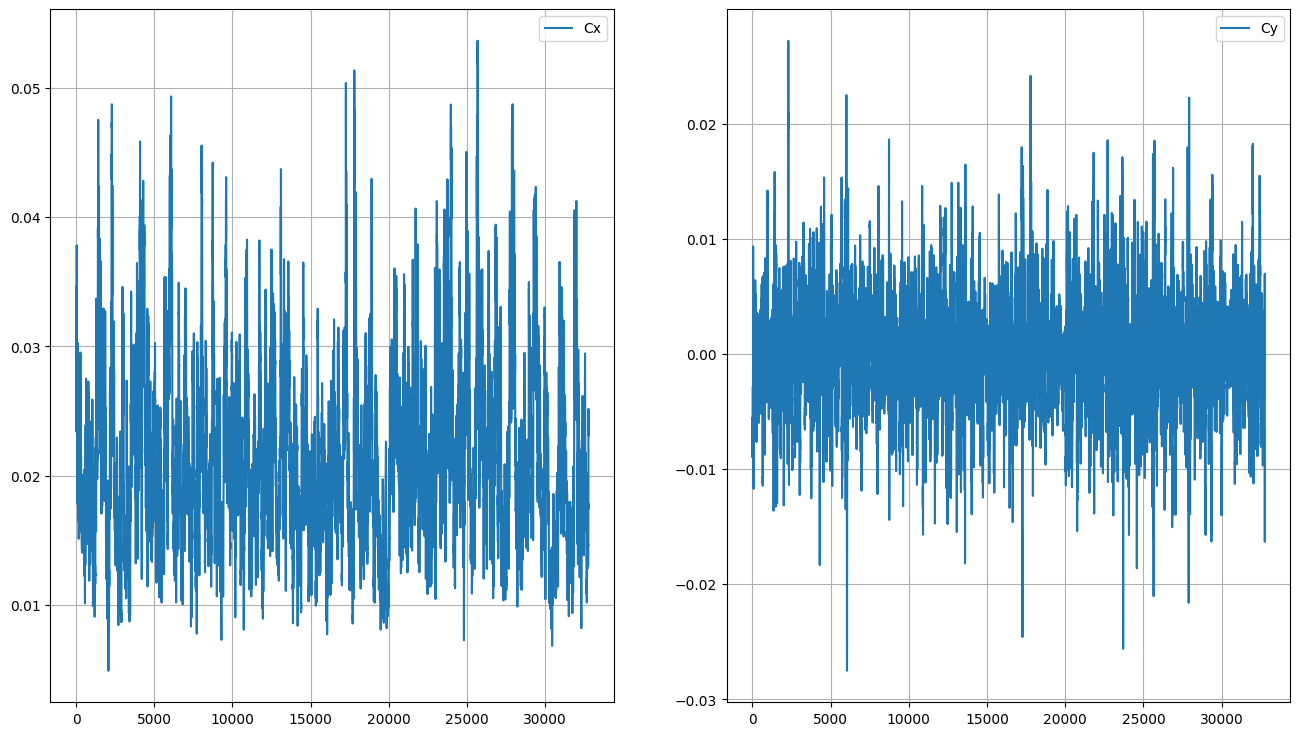

In [247]:
fig,graph = plt.subplots(1,2,figsize=(16,9))
graph[0].plot(list(range(1,32769)),sum_x,label='Cx')
graph[1].plot(list(range(1,32769)),sum_y,label='Cy')
graph[0].legend()
graph[1].legend()
graph[0].grid()
graph[1].grid()
plt.show()

In [248]:
sum(sum_x)/32768

0.02127154055175778

In [249]:
sum(sum_y)/32768

3.435385742187068e-05

In [54]:
count_sensors_on_model

100